<a href="https://colab.research.google.com/github/pucuk-yusup/Portofolio-Analisis/blob/main/Credit_Risk_Scoring_Model_to_Predict_Loan_Default_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Dataset

In [1]:
# Upload Data
import pandas as pd
df = pd.read_csv("loan_data.csv")
df.head()


,Loan_ID,Loan_Amount,Tenure,Applicant_Income,DTI,Credit_History,Num_Late_Payments,Default
0,1,12752020,15,8152044,0.128,0,1,1
1,2,7476152,38,4161677,0.066,1,0,0
2,3,9011814,13,10187238,0.090,1,0,0
3,4,21042324,17,11203122,0.131,1,2,0
4,5,5000000,44,2638980,0.054,1,0,0


EDA

In [2]:
#EDA
df.info()
df.describe(include="all")
df["Default"].value_counts(normalize=True)
df.isna().mean()  # cek missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            6000 non-null   int64  
 1   Loan_Amount        6000 non-null   int64  
 2   Tenure             6000 non-null   int64  
 3   Applicant_Income   6000 non-null   int64  
 4   DTI                6000 non-null   float64
 5   Credit_History     6000 non-null   int64  
 6   Num_Late_Payments  6000 non-null   int64  
 7   Default            6000 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 375.1 KB


,0
Loan_ID,0.0
Loan_Amount,0.0
Tenure,0.0
Applicant_Income,0.0
DTI,0.0
Credit_History,0.0
Num_Late_Payments,0.0
Default,0.0


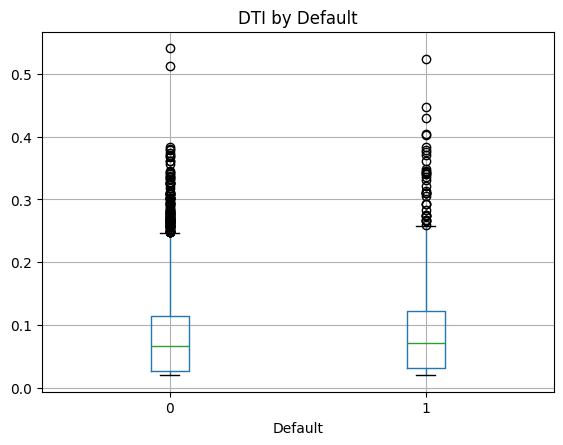

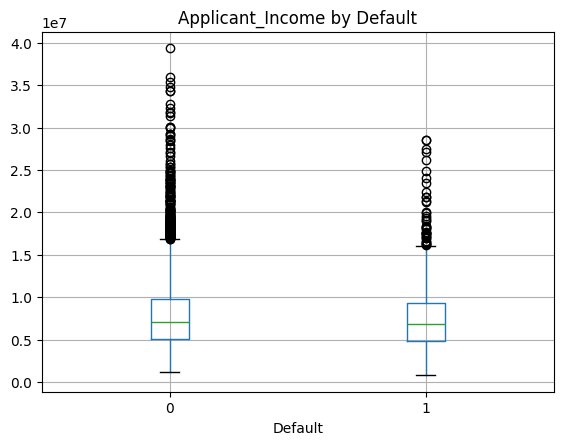

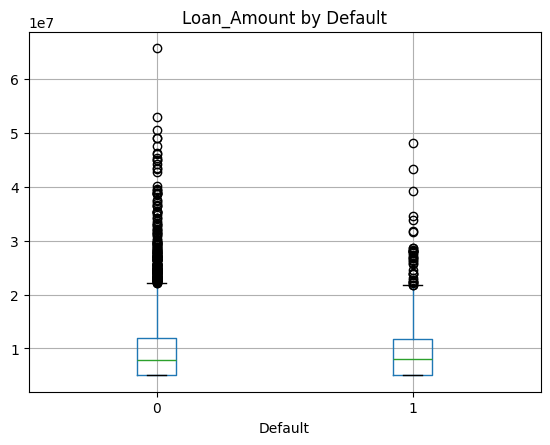

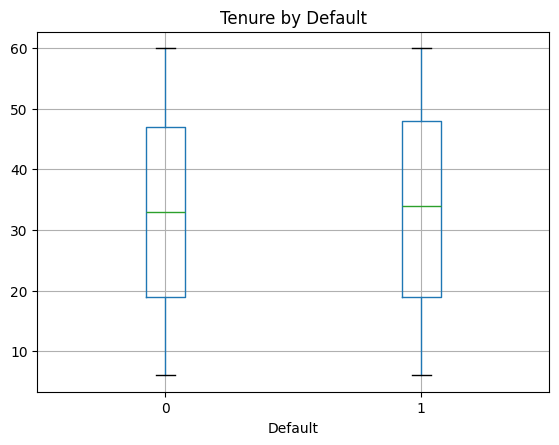

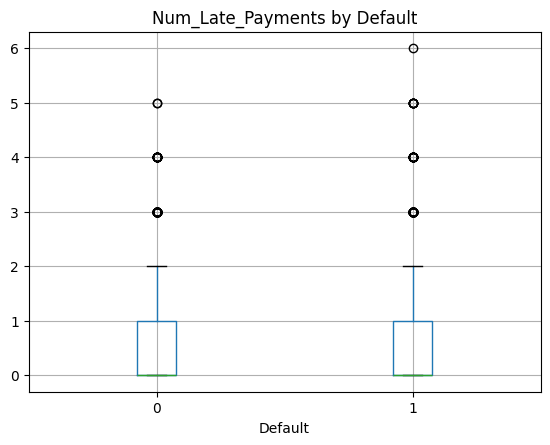

In [3]:
#Plot hubungan fitur vs default:
import matplotlib.pyplot as plt

for col in ["DTI","Applicant_Income","Loan_Amount","Tenure","Num_Late_Payments"]:
    df.boxplot(column=col, by="Default")
    plt.title(f"{col} by Default")
    plt.suptitle("")
    plt.show()


Train–Test Split & Scaling (untuk LogReg)

In [4]:
#Train–Test Split & Scaling (untuk LogReg)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["Loan_Amount","Tenure","Applicant_Income","DTI","Credit_History","Num_Late_Payments"]
X = df[features].copy()
y = df["Default"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7, stratify=y
)

num_cols = ["Loan_Amount","Tenure","Applicant_Income","DTI","Num_Late_Payments"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])


Train Model: Logistic Regression & Random Forest

In [5]:
#Train Model: Logistic Regression & Random Forest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=7,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=300, n_jobs=-1, random_state=7)

Evaluasi Model (ROC-AUC, Accuracy, Classification Report)

In [6]:
#Evaluasi Model (ROC-AUC, Accuracy, Classification Report)
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Probabilitas default (PD) di test set
log_pd = log_model.predict_proba(X_test_scaled)[:,1]
rf_pd  = rf_model.predict_proba(X_test)[:,1]

# Skor
log_auc = roc_auc_score(y_test, log_pd)
rf_auc  = roc_auc_score(y_test, rf_pd)

log_acc = accuracy_score(y_test, (log_pd >= 0.5).astype(int))
rf_acc  = accuracy_score(y_test, (rf_pd  >= 0.5).astype(int))

print(f"LogReg - AUC: {log_auc:.4f}  | Acc@0.5: {log_acc:.4f}")
print(f"RandFor - AUC: {rf_auc:.4f}  | Acc@0.5: {rf_acc:.4f}")

print("\nClassification Report (Random Forest @0.5):")
print(classification_report(y_test, (rf_pd >= 0.5).astype(int)))


LogReg - AUC: 0.6626  | Acc@0.5: 0.7856
RandFor - AUC: 0.6492  | Acc@0.5: 0.7728

Classification Report (Random Forest @0.5):
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1417
           1       0.41      0.15      0.21       383

    accuracy                           0.77      1800
   macro avg       0.60      0.54      0.54      1800
weighted avg       0.72      0.77      0.73      1800



Hitung PD untuk seluruh data + Tentukan Risk Band

In [7]:
#Hitung PD untuk seluruh data + Tentukan Risk Band
# Pilih model terbaik berdasar AUC
best_model = rf_model if rf_auc >= log_auc else log_model
use_scaler = (best_model is log_model)

X_full = X.copy()
if use_scaler:
    X_full[num_cols] = scaler.transform(X_full[num_cols])

df["PD"] = best_model.predict_proba(X_full)[:,1]

# Risk Band thresholds (sederhana & transparan)
df["Risk_Band"] = pd.cut(
    df["PD"],
    bins=[0.0, 0.33, 0.66, 1.0],
    labels=["Low Risk","Medium Risk","High Risk"],
    include_lowest=True
)

df[["Loan_ID","PD","Risk_Band","Default"]].head()


,Loan_ID,PD,Risk_Band,Default
0,1,0.427442,Medium Risk,1
1,2,0.147896,Low Risk,0
2,3,0.114875,Low Risk,0
3,4,0.185931,Low Risk,0
4,5,0.152918,Low Risk,0


KPI: Bad Loan Ratio per Risk Band

In [8]:
#KPI: Bad Loan Ratio per Risk Band
band_summary = df.groupby("Risk_Band").agg(
    Customers=("Loan_ID","count"),
    Bad_Loans=("Default","sum"),
    Bad_Loan_Ratio=("Default","mean"),
    Avg_PD=("PD","mean")
).reset_index()

band_summary.sort_values("Risk_Band")


/tmp/ipython-input-3110814983.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_summary = df.groupby("Risk_Band").agg(


,Risk_Band,Customers,Bad_Loans,Bad_Loan_Ratio,Avg_PD
0,Low Risk,4656,696,0.149485,0.146886
1,Medium Risk,1338,576,0.430493,0.436379
2,High Risk,6,5,0.833333,0.697839


Ekspor Data Siap Pakai untuk Tableau

In [9]:
#Ekspor untuk Tableau
#1.Prediksi per nasabah (Tableau Fact):
df_out = df[["Loan_ID","Loan_Amount","Tenure","Applicant_Income","DTI",
             "Credit_History","Num_Late_Payments","PD","Risk_Band","Default"]]
df_out.to_csv("loan_risk_output.csv", index=False)


In [10]:
#2.Summary KPI per Risk Band (Tableau KPI Table):
band_summary.to_csv("loan_band_summary.csv", index=False)

Feature Importance & SHAP (buat interpretasi model)

In [11]:
#Random Forest Feature Importance
import numpy as np
import pandas as pd

importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values("Importance", ascending=False)
feat_imp


,Feature,Importance
2,Applicant_Income,0.256163
3,DTI,0.203807
0,Loan_Amount,0.203537
1,Tenure,0.178427
4,Credit_History,0.107789
5,Num_Late_Payments,0.050277


sv shape: (1800, 6, 2) | X_test shape: (1800, 6)


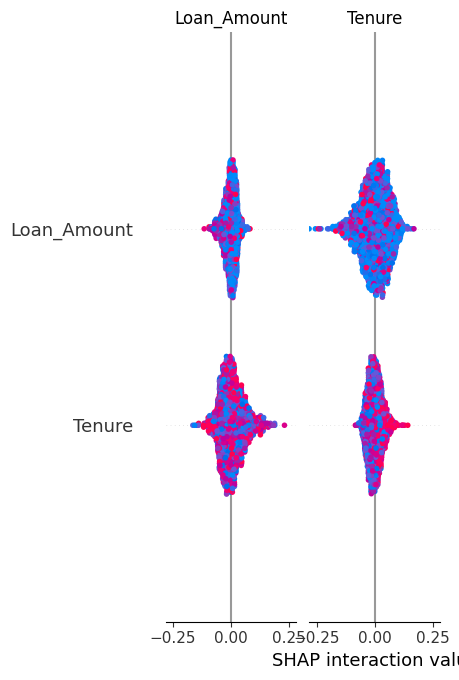

In [13]:
#Fix A (robust untuk berbagai versi SHAP)
!pip install shap -q
import shap

# Inisialisasi explainer untuk RandomForest
explainer = shap.TreeExplainer(rf_model)

# Pakai numpy biar aman dari isu index/kolom
X_test_np = X_test.values
feature_names = X_test.columns.tolist()

shap_values = explainer.shap_values(X_test_np)

# Old API -> list per class; New API -> array
if isinstance(shap_values, list):
    sv = shap_values[1]  # class 1 = default
else:
    sv = shap_values     # sudah (n_samples, n_features)

# Pastikan shape cocok: sv.shape == (len(X_test), len(features))
print("sv shape:", sv.shape, "| X_test shape:", X_test_np.shape)

# Plot (legacy summary_plot)
shap.summary_plot(sv, features=X_test_np, feature_names=feature_names, show=False)



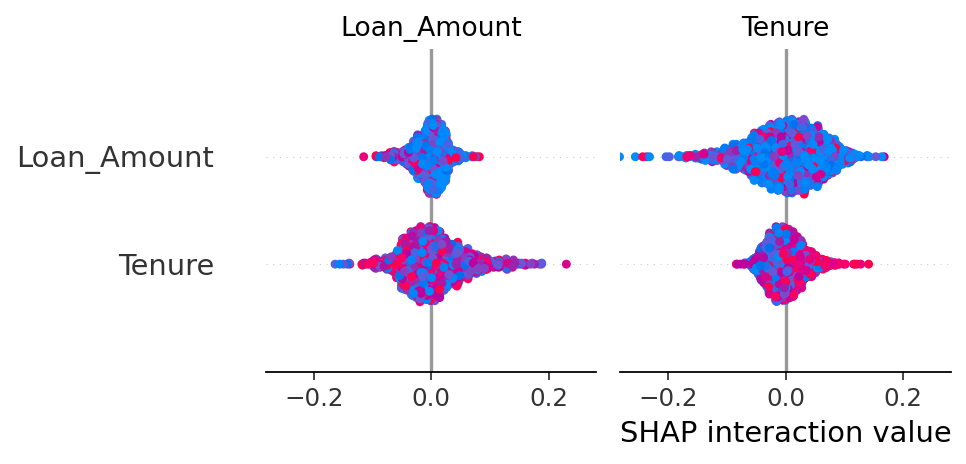

In [34]:
#perbaikan visualisasi
import matplotlib.pyplot as plt

# set tampilan yang lega
plt.rcParams["figure.dpi"] = 160

# summary_plot (legacy) dengan ukuran & limit fitur
shap.summary_plot(
    sv,
    features=X_test_np,
    feature_names=feature_names,
    show=False,
    plot_size=(15, 3),   # lebar x tinggi (inch)
    max_display=12       # jumlah fitur yang ditampilkan
)

# pastikan tidak terpotong
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.tight_layout()
plt.show()

# opsional: simpan gambar high-res
fig.savefig("shap_beeswarm.png", bbox_inches="tight", dpi=220)


sv shape: (1800, 6, 2) | X_test shape: (1800, 6)


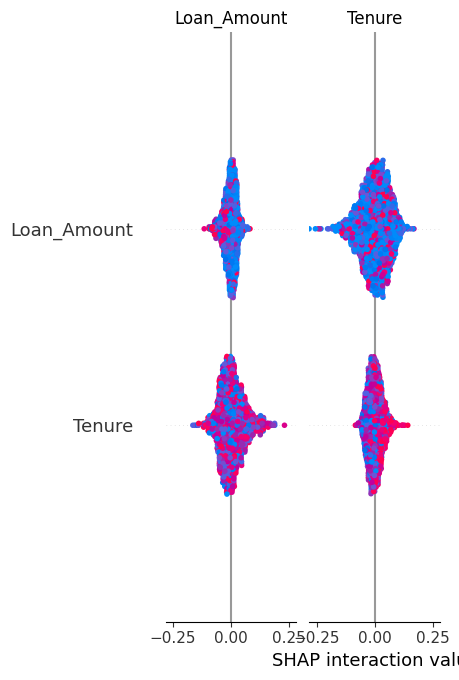

In [17]:
#Fix B (legacy API, aman lintas versi)
!pip install -q shap
import shap
import numpy as np
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(rf_model)

# Pakai numpy agar bebas dari isu index/kolom
X_test_np = X_test.values
feature_names = X_test.columns.tolist()

shap_values = explainer.shap_values(X_test_np)

# Jika shap_values berupa list per-class, ambil kelas 1 (default)
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

print("sv shape:", sv.shape, "| X_test shape:", X_test_np.shape)  # harus cocok kolomnya

shap.summary_plot(sv, features=X_test_np, feature_names=feature_names, show=False)
plt.show()


sv shape: (1800, 6, 2) | X_test shape: (1800, 6)


<Figure size 1920x600 with 0 Axes>

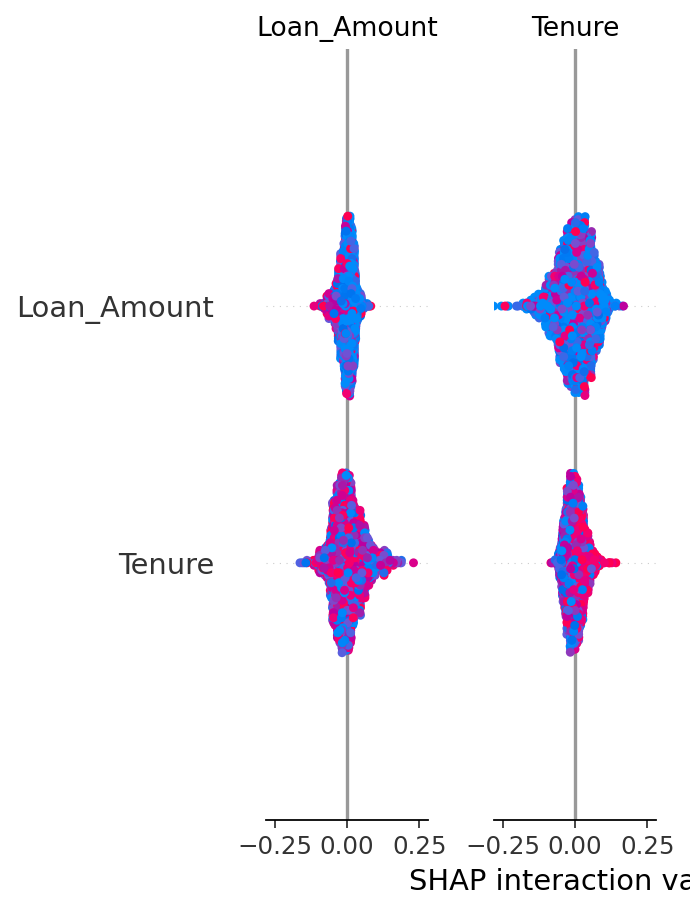

<Figure size 1024x768 with 0 Axes>

In [37]:
#perbaikan visualisasi
!pip install -q shap
import shap
import numpy as np
import matplotlib.pyplot as plt

# Buat explainer
explainer = shap.TreeExplainer(rf_model)

# Ubah X_test ke numpy array biar stabil
X_test_np = X_test.values
feature_names = X_test.columns.tolist()

# Dapatkan shap values
shap_values = explainer.shap_values(X_test_np)
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

print("sv shape:", sv.shape, "| X_test shape:", X_test_np.shape)

# --- Pengaturan visual agar tidak terpotong ---
plt.figure(figsize=(16, 5), dpi=120)  # ukuran besar dan resolusi tinggi
shap.summary_plot(
    sv,
    features=X_test_np,
    feature_names=feature_names,
    show=False,
    plot_size=(16, 5),
    max_display=10  # tampilkan 10 fitur teratas saja agar rapi
)

plt.tight_layout()                # rapikan margin
plt.show()

# (Opsional) Simpan gambar high-res
plt.savefig("shap_summary_full.png", bbox_inches="tight", dpi=200)


Partial Dependence Plot (PDP + ICE)

In [39]:
# === PDP & ICE untuk RandomForest ===
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Pilih fitur yang mau dianalisis (pakai nama kolom persis di X_train/X_test)
pdp_features = ["DTI", "Credit_History", "Num_Late_Payments", "Loan_Amount", "Tenure"]

<Figure size 910x780 with 0 Axes>

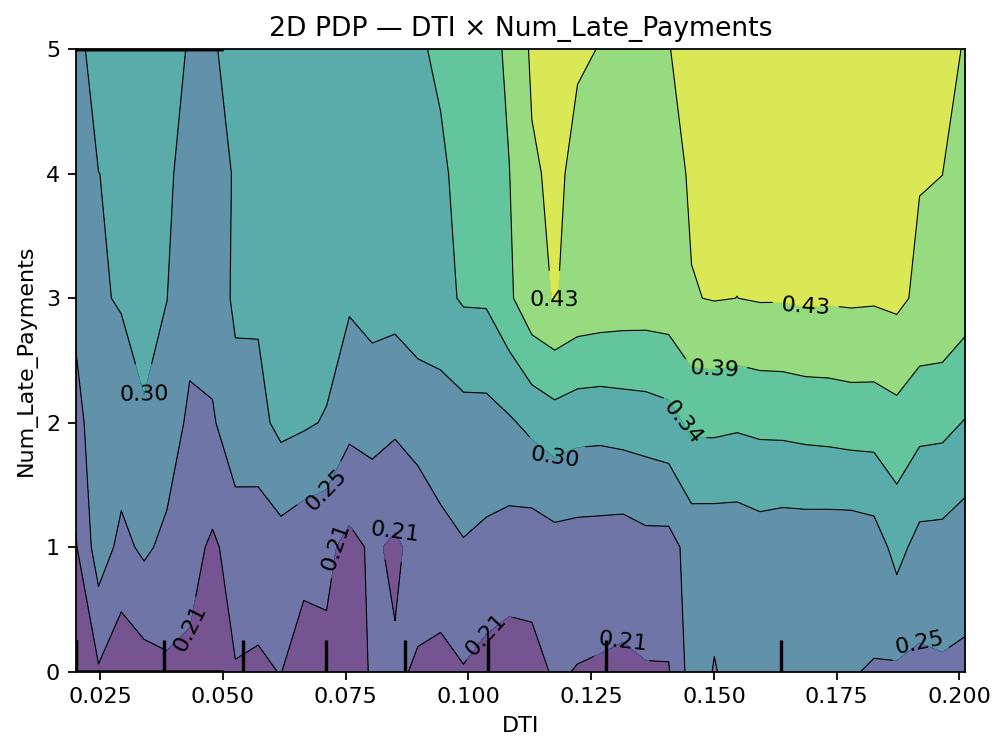

In [55]:
# 2D interaction PDP (contoh: DTI vs Num_Late_Payments)
fig = plt.figure(figsize=(7,6), dpi=130)
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_test,
    [("DTI", "Num_Late_Payments")],
    kind="average",
    method="brute",
    response_method="predict_proba",
    target=1,
    grid_resolution=40,
)
plt.title("2D PDP — DTI × Num_Late_Payments")
plt.tight_layout()
# Simpan visualisasi ke file (ubah format sesuai kebutuhan)
plt.savefig("pdp_2d_DTI_vs_LatePayments.png", bbox_inches="tight", dpi=300)
# Atau versi PDF untuk laporan:
# plt.savefig("pdp_2d_DTI_vs_LatePayments.pdf", bbox_inches="tight")
plt.show()

Threshold Tuning (ROC, PR, target TPR, biaya)

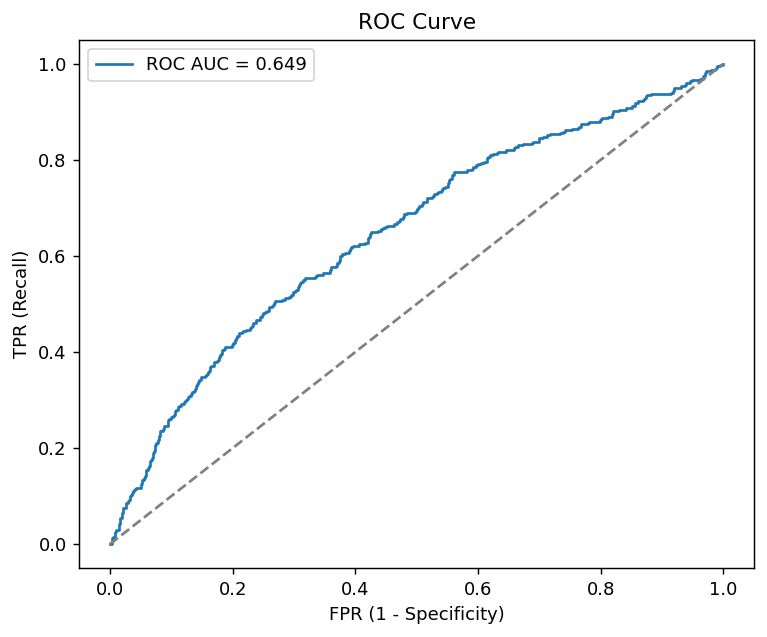

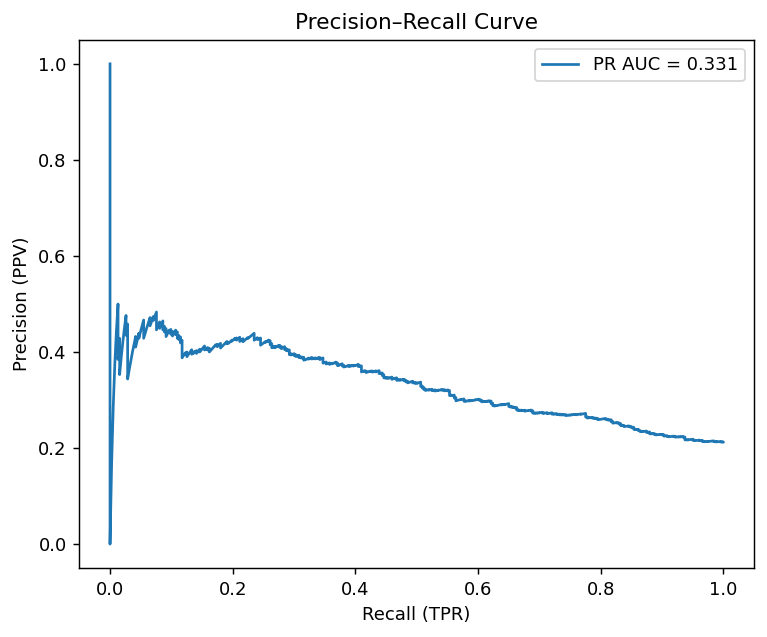

,threshold,TPR,FPR,TNR,Precision,NPV,Accuracy
0,0.01,1.000000,1.000000,0.000000,0.212778,0.000000,0.212778
1,0.02,0.997389,0.995060,0.004940,0.213170,0.875000,0.216111
2,0.03,0.986945,0.982357,0.017643,0.213559,0.833333,0.223889
3,0.04,0.973890,0.968243,0.031757,0.213754,0.818182,0.232222
4,0.05,0.960836,0.940720,0.059280,0.216343,0.848485,0.251111
5,0.06,0.937337,0.908963,0.091037,0.217972,0.843137,0.271111
6,0.07,0.924282,0.869442,0.130558,0.223203,0.864486,0.299444
7,0.08,0.900783,0.826394,0.173606,0.227573,0.866197,0.328333
8,0.09,0.877285,0.779817,0.220183,0.233171,0.869081,0.360000
9,0.10,0.853786,0.729005,0.270995,0.240441,0.872727,0.395000


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

# Prob default di test set (RandomForest)
rf_pd = rf_model.predict_proba(X_test)[:,1]

# === 2.1 ROC & PR Curves ===
fpr, tpr, thr_roc = roc_curve(y_test, rf_pd)
roc_auc = auc(fpr, tpr)

prec, rec, thr_pr = precision_recall_curve(y_test, rf_pd)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5), dpi=130)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5), dpi=130)
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# === 2.2 Grid metrics across thresholds ===
def metrics_at_threshold(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp+fn)>0 else 0.0     # Recall
    fpr = fp / (fp + tn) if (fp+tn)>0 else 0.0
    tnr = 1 - fpr                                  # Specificity
    ppv = tp / (tp + fp) if (tp+fp)>0 else 0.0     # Precision
    npv = tn / (tn + fn) if (tn+fn)>0 else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn)
    return dict(threshold=thr, TPR=tpr, FPR=fpr, TNR=tnr, Precision=ppv, NPV=npv, Accuracy=acc)

grid = np.linspace(0.01, 0.99, 99)
rows = [metrics_at_threshold(y_test, rf_pd, t) for t in grid]
thr_df = pd.DataFrame(rows)

# Tampilkan 10 baris contoh
thr_df.head(10)


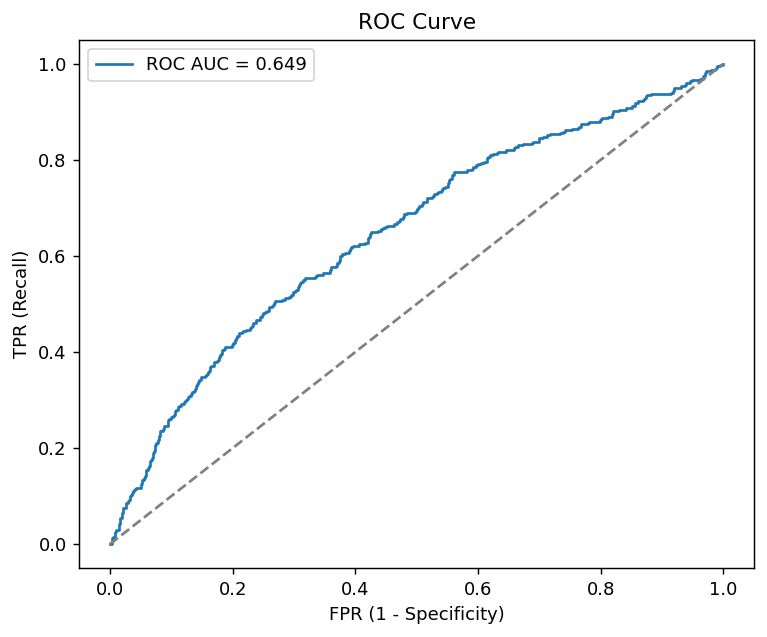

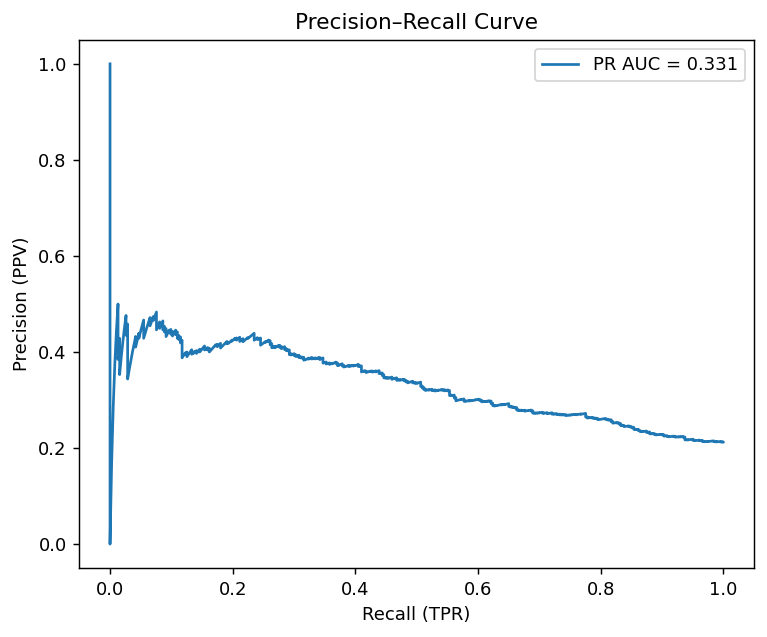

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix

# Prob default di test set (RandomForest)
rf_pd = rf_model.predict_proba(X_test)[:,1]

# === 2.1 ROC Curve ===
fpr, tpr, thr_roc = roc_curve(y_test, rf_pd)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5), dpi=130)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("FPR (1 - Specificity)")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()

# Simpan gambar ke file (format bebas: .png / .jpg / .pdf)
plt.savefig("roc_curve.png", bbox_inches="tight", dpi=300)
plt.show()


# === 2.1 Precision–Recall Curve ===
prec, rec, thr_pr = precision_recall_curve(y_test, rf_pd)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5), dpi=130)
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()

# Simpan juga PR curve
plt.savefig("precision_recall_curve.png", bbox_inches="tight", dpi=300)
plt.show()


a) Pilih threshold berdasar risk appetite (target TPR)

Misal bank ingin menangkap ≥ 75% calon default (Recall/TPR ≥ 0.75):

In [44]:
target_tpr = 0.75
# ambil threshold dengan TPR terdekat di atas/sekitar target_tpr, lalu pilih yang meminimalkan FPR
candidates = thr_df.loc[thr_df["TPR"] >= target_tpr]
if not candidates.empty:
    # pilih yang FPR-nya paling kecil
    best_row = candidates.sort_values(["FPR","TPR"]).iloc[0]
else:
    # kalau nggak ada yang >= target, ambil TPR terdekat dari bawah
    idx = (thr_df["TPR"] - target_tpr).abs().argmin()
    best_row = thr_df.iloc[idx]

best_thr_tpr = best_row["threshold"]
best_row


,12
threshold,0.130000
TPR,0.775457
FPR,0.573042
TNR,0.426958
Precision,0.267809
NPV,0.875543
Accuracy,0.501111


b) Pilih threshold berdasar biaya (cost-sensitive)

Misal biaya FN (gagal mendeteksi default) = 5 unit, biaya FP (false alarm) = 1 unit (gampang diganti sesuai kebijakan)

In [45]:
def total_cost(y_true, y_score, thr, cost_fp=1.0, cost_fn=5.0):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp*cost_fp + fn*cost_fn

thr_cost = []
for t in grid:
    c = total_cost(y_test, rf_pd, t, cost_fp=1.0, cost_fn=5.0)
    thr_cost.append((t, c))
thr_cost = pd.DataFrame(thr_cost, columns=["threshold","cost"])

best_row_cost = thr_cost.loc[thr_cost["cost"].idxmin()]
best_thr_cost = best_row_cost["threshold"]
best_row_cost


,12
threshold,0.13
cost,1242.00


c) (Opsional) Pilih threshold maksimum KS statistic

Sering dipakai di risk scoring tradisional.

In [46]:
ks_values = tpr - fpr
best_idx = np.argmax(ks_values)
best_thr_ks = thr_roc[best_idx]
ks_stat = ks_values[best_idx]
best_thr_ks, ks_stat


(np.float64(0.2425070273723525), np.float64(0.23764950406385715))

d) Bandingkan tiga threshold (TPR-target, Cost, KS)

In [47]:
def cm_report(y_true, y_score, thr):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return pd.Series({
        "threshold": thr,
        "TPR": tp/(tp+fn) if (tp+fn)>0 else 0,
        "FPR": fp/(fp+tn) if (fp+tn)>0 else 0,
        "Precision": tp/(tp+fp) if (tp+fp)>0 else 0,
        "Accuracy": (tp+tn)/(tp+tn+fp+fn)
    })

compare = pd.concat([
    cm_report(y_test, rf_pd, float(best_thr_tpr)).rename("Target_TPR"),
    cm_report(y_test, rf_pd, float(best_thr_cost)).rename("Min_Cost"),
    cm_report(y_test, rf_pd, float(best_thr_ks)).rename("Max_KS"),
], axis=1).T

compare


,threshold,TPR,FPR,Precision,Accuracy
Target_TPR,0.130000,0.775457,0.573042,0.267809,0.501111
Min_Cost,0.130000,0.775457,0.573042,0.267809,0.501111
Max_KS,0.242507,0.506527,0.268878,0.337391,0.683333


Bonus: Simpan threshold pilihan untuk scoring harian

In [48]:
# Misal ambil berdasarkan target TPR
FINAL_THRESHOLD = float(best_thr_tpr)

# Terapkan ke seluruh data (untuk KPI operasional)
df_score = X_test.copy()
df_score["PD"] = rf_pd
df_score["Pred_Default"] = (df_score["PD"] >= FINAL_THRESHOLD).astype(int)
df_score.head()


,Loan_Amount,Tenure,Applicant_Income,DTI,Credit_History,Num_Late_Payments,PD,Pred_Default
1111,5000000,43,6110893,0.028,0,0,0.483703,1
3730,5000000,43,4845421,0.093,1,0,0.065698,0
5510,14170617,50,8559937,0.033,1,0,0.095794,0
3680,5000000,21,5100217,0.063,1,0,0.073213,0
3440,31470992,24,18859944,0.104,1,0,0.094671,0
